In [39]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Function
import torch.optim as optim

import torchvision

from matplotlib import pyplot
import scipy.io as sio
import numpy as np

import h5py
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#  

# device = torch.device("cuda:0" if 0 else "cpu")# torch.cuda.is_available() 

In [40]:
data = torchvision.datasets.MNIST('',download=True)
data_mnist = data.data
label_mnist = data.targets
print(data_mnist.shape)
print(label_mnist.shape)
shape_new = (data_mnist.shape[0],3,data_mnist.shape[1],data_mnist.shape[2])
data_new = np.zeros(shape_new)
data_new[:,0,:,:] = data_mnist
data_new[:,1,:,:] = data_mnist
data_new[:,2,:,:] = data_mnist
data_mnist = data_new
print(data_mnist.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
(60000, 3, 28, 28)


array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

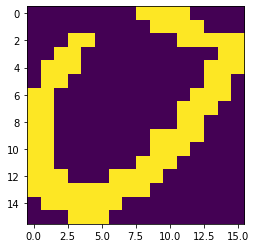

In [41]:
# cited from: https://www.jianshu.com/p/34ce0edffbf9
INPUT_NODE = 256
OUTPUT_NODE = 10
LAYER1_NODE = 500

NUM_OF_TRAINING = 1559
NUM_OF_TESTING = 1
def load_data():
    #从文件中逐行读取数据
    fr = open('semeion.data', 'r', encoding='utf-8')
    arrayOfLines = fr.readlines()
    #初始化训练特征矩阵，训练标签矩阵，测试特征矩阵和测试标签矩阵
    trainingImages = np.zeros([NUM_OF_TRAINING, INPUT_NODE])
    trainingLabels = np.zeros([NUM_OF_TRAINING, OUTPUT_NODE])
    testingImages = np.zeros([NUM_OF_TESTING, INPUT_NODE])
    testingLabels = np.zeros([NUM_OF_TESTING, OUTPUT_NODE])
    #处理用于训练的数据
    for i in range(NUM_OF_TRAINING):
        #去掉每一行末尾的空格和回车
        arrayOfLines[i] = arrayOfLines[i].rstrip(' \n')
        #将一行数据以空格分开存入列表
        currentLine = arrayOfLines[i].split(' ')
        #将特征值存入特征矩阵
        trainingImages[i][:] = currentLine[:256]
        #将标签值存入标签矩阵
        trainingLabels[i][:] = currentLine[256:]
    #处理用于测试的数据
    for i in range(NUM_OF_TESTING):
        #去掉每一行末尾的空格和回车
        arrayOfLines[i+NUM_OF_TRAINING] = arrayOfLines[i+NUM_OF_TRAINING].rstrip(' \n')
        #将一行数据以空格分开存入列表
        currentLine = arrayOfLines[i+NUM_OF_TRAINING].split(' ')
        #将特征值存入特征矩阵
        testingImages[i][:] = currentLine[:256]
        #将标签值存入标签矩阵
        testingLabels[i][:] = currentLine[256:]
    #返回处理后的矩阵
    return trainingImages,trainingLabels,testingImages,testingLabels

usps_X_train,usps_y_train,usps_X_test,usps_y_test = load_data()
usps_X_train = usps_X_train.reshape((usps_X_train.shape[0],16,16))
usps_X_test = usps_X_test.reshape((usps_X_test.shape[0],16,16))

usps_y_train = np.argmax(usps_y_train,1)
usps_y_test = np.argmax(usps_y_test,1)
pyplot.imshow(usps_X_train[19])
usps_y_train
# pyplot.plot((np.argmax(usps_y_train,1)))

In [42]:
usps_X_train.shape, usps_y_train.shape, usps_X_test.shape, usps_y_test.shape

print(usps_X_train.shape)
print(usps_y_train.shape)
shape_new = (usps_X_train.shape[0],3,usps_X_train.shape[1],usps_X_train.shape[2])
data_new = np.zeros(shape_new)
data_new[:,0,:,:] = usps_X_train
data_new[:,1,:,:] = usps_X_train
data_new[:,2,:,:] = usps_X_train
data_usps = data_new
print(data_usps.shape)

(1559, 16, 16)
(1559,)
(1559, 3, 16, 16)


In [43]:
# svhn -> mnist
N_train = 73257
N_test = 26032

X_train = data_mnist
print(X_train.shape)
y_train = label_mnist
y_train[y_train==10] = 0
mnist_0_4 = y_train < 5
X_train = X_train[mnist_0_4,:,:,:]
y_train = y_train[mnist_0_4]

X_test = data_usps
y_test = usps_y_train
y_test[y_test==10] = 0
usps_0_4 = y_test < 5
X_test = X_test[usps_0_4,:,:,:]
y_test = y_test[usps_0_4]

X_train_torch = torch.tensor(X_train).to(torch.float32)
y_train_torch = torch.tensor(y_train).to(torch.float32)

X_test_torch = torch.tensor(X_test).to(torch.float32)
y_test_torch = torch.tensor(y_test).to(torch.float32)


N_train = y_train.shape[0]
N_test = y_test.shape[0]
print(N_train)
print(N_test)

(60000, 3, 28, 28)
30596
802


<ipython-input-43-1e10833fc60d>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_torch = torch.tensor(y_train).to(torch.float32)


In [44]:
print(X_test_torch.shape)
trans1 = torchvision.transforms.ToPILImage()
X_test_torch_resize = np.zeros((X_test_torch.shape[0],3,32,32))
for i in range(X_test_torch.shape[0]):
    image = torchvision.transforms.functional.resize(trans1(X_test_torch[i,:,:,:]),(32,32))
    image = np.array(image)
    image = image.swapaxes(0,2)
    image = image.swapaxes(1,2)
    X_test_torch_resize[i,:,:,:] = image
X_test_torch = torch.tensor(X_test_torch_resize).to(torch.float32)
print(X_test_torch.shape)

print(X_train_torch.shape)
trans1 = torchvision.transforms.ToPILImage()
X_train_torch_resize = np.zeros((X_train_torch.shape[0],3,32,32))
for i in range(X_train_torch.shape[0]):
    image = torchvision.transforms.functional.resize(trans1(X_train_torch[i,:,:,:]),(32,32))
    image = np.array(image)
    image = image.swapaxes(0,2)
    image = image.swapaxes(1,2)
    X_train_torch_resize[i,:,:,:] = image
X_train_torch = torch.tensor(X_train_torch_resize).to(torch.float32)
print(X_train_torch.shape)

torch.Size([802, 3, 16, 16])
torch.Size([802, 3, 32, 32])
torch.Size([30596, 3, 28, 28])


KeyboardInterrupt: 

In [ ]:
pyplot.imshow(X_test_torch[800,1,:,:])

In [ ]:
X_test_torch = X_test_torch / 255.0
X_train_torch = X_train_torch / 255.0
print(torch.min(X_test_torch))
print(torch.max(X_test_torch))
print(torch.min(X_train_torch))
print(torch.max(X_train_torch))

In [ ]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

def flip_gradient(x, l=1.0):
    with torch.no_grad():
        positive_path = (x * (l+1))# (x * tf.cast(1 + l, tf.float32))
        negative_path = -x * l
    return positive_path + negative_path

class GRLModel(nn.Module):
    def __init__(self):
        super(GRLModel, self).__init__()
        # Feature Encoders
        self.feature = nn.Sequential()
        # CNN layer 1
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, stride=1, kernel_size=5, padding=0))
        self.feature.add_module('f_drop1', nn.Dropout(0.2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2,stride=2))
        # CNN layer 2
        self.feature.add_module('f_conv2', nn.Conv2d(64, 64, stride=1, kernel_size=5, padding=0))
        self.feature.add_module('f_drop2', nn.Dropout(0.2))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2,stride=2))
        # CNN layer 3
        self.feature.add_module('f_conv3', nn.Conv2d(64,128, stride=1, kernel_size=5, padding=0))
        self.feature.add_module('f_drop3', nn.Dropout(0.2))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('latent', nn.Flatten())
        
        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(128, 128))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_fc2', nn.Linear(128, 5))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        # self.class_classifier.add_module('c_softmax', nn.Softmax())
        
        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(128, 128))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(128, 1))
        self.domain_classifier.add_module('d_relu2', nn.ReLU(True))
        self.domain_classifier.add_module('d_sigmoid', nn.Sigmoid())

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 32, 32)
        feature = self.feature(input_data)
        reverse_feature = ReverseLayerF.apply(feature, alpha) # GRL output
        # reverse_feature = flip_gradient(feature)
        class_output = self.class_classifier(feature)
        # print(reverse_feature.shape)
        domain_output = self.domain_classifier(reverse_feature)
        
        # add feature as output
        return feature, class_output, domain_output

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.feature = nn.Sequential()
        # CNN layer 1
        self.feature.add_module('f_conv1', nn.ConvTranspose2d(128, 512, stride=1, kernel_size=2, padding=0))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(512))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        # CNN layer 2
        self.feature.add_module('f_conv2', nn.ConvTranspose2d(512, 256, stride=2, kernel_size=4, padding=1))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(256))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        # CNN layer 3
        self.feature.add_module('f_conv3', nn.ConvTranspose2d(256, 128, stride=2, kernel_size=4, padding=1))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(128))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        # CNN layer 4
        self.feature.add_module('f_conv4', nn.ConvTranspose2d(128, 64, stride=2, kernel_size=4, padding=1))
        self.feature.add_module('f_bn4', nn.BatchNorm2d(64))
        self.feature.add_module('f_relu4', nn.ReLU(True))
        # CNN layer 5
        self.feature.add_module('f_conv5', nn.ConvTranspose2d(64, 3, stride=2, kernel_size=4, padding=1))
        self.feature.add_module('f_relu5', nn.Tanh())
        
    def forward(self, input_data):
        return self.feature(input_data)
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        # CNN layer 1
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, stride=1, kernel_size=3, padding=1))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_relu1', nn.LeakyReLU())
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2,stride=2))
        # CNN layer 2
        self.feature.add_module('f_conv2', nn.Conv2d(64, 128, stride=1, kernel_size=3, padding=1))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(128))
        self.feature.add_module('f_relu2', nn.LeakyReLU())        
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2,stride=2))
        # CNN layer 3
        self.feature.add_module('f_conv3', nn.Conv2d(128, 256, stride=1, kernel_size=3, padding=1))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(256))
        self.feature.add_module('f_relu3', nn.LeakyReLU())
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=4,stride=4))
        self.feature.add_module('f_flat', nn.Flatten())
        
        self.lin_bin = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()
        # self.lin_aux = nn.Linear(1024, 5)
        
    def forward(self, input_data):
        input_data = input_data.expand(input_data.data.shape[0], 3, 32, 32)
        out = self.feature(input_data)
        out_lin = self.lin_bin(out)
        out_bin = self.sigmoid(out_lin)
        # out_aux = self.lin_aux(out) # may not necessary in ALOCC+GRL
        return out_bin, out_lin

In [ ]:
torch.cuda.empty_cache()
GRL = GRLModel().to(device) # feature-net class-classifier domain-classifier
D = Discriminator().to(device) # output the real or fake
G = Generator().to(device) # output the reconstructed image

image = torch.randn((1,3,32,32)).to(device)
feature, class_output, domain_output = GRL(image,0.01) # 128x1 5x1 2x1

G_input = torch.randn((97,128,1,1)).to(device) # 128x1x1
G_output = G(G_input).to(device) # 3x32x32
D_output_bin, D_output_lin = D(G_output) # 1 5
print(feature.shape)
print(class_output)
print(domain_output.shape)
print(G_input.shape)
print(G_output.shape)
print(D_output_lin.shape)


In [ ]:
LearningRate = 0.0001
# Beta1 = 0.5
Iter = 10000
Batch_size = 16
Alpha = 0.2 # gradient reverse layer
Noise = 0.01
Lambda_gan = 0.2

GRL_optimizer = optim.Adam(GRL.parameters(),lr=LearningRate)
D_optimizer = optim.Adam(D.parameters(),lr=LearningRate)
G_optimizer = optim.Adam(G.parameters(),lr=LearningRate)

Cat_Loss = nn.CrossEntropyLoss()
L1_Loss = nn.L1Loss()
BCE_Loss = nn.BCELoss()
NLL_Loss = nn.NLLLoss()
RMSE_Loss = nn.MSELoss()

In [ ]:
Batch_size = 32
batch_sample =  np.random.randint(0,N_train-1,size=(Batch_size))
# feature, class_output, domain_output = GRL(X_train_torch[batch_sample,:,:,:],0.01)

one_tensor = torch.ones(Batch_size).to(torch.long).detach().to(device)
zero_tensor = torch.zeros(Batch_size).to(torch.long).detach().to(device)

zero_bin = torch.cat((one_tensor.reshape(Batch_size,1), zero_tensor.reshape(Batch_size,1)),dim=1).type(torch.float32)
one_bin = torch.cat((zero_tensor.reshape(Batch_size,1), one_tensor.reshape(Batch_size,1)),dim=1).type(torch.float32)
ce_loss_list = []
GRL_loss_list = []
D_loss_list = []
G_loss_list = []

In [ ]:
for i in range(Iter * 10):
    train_sample = np.random.randint(0,N_train-1,size=(Batch_size))
    test_sample = np.random.randint(0,N_test-1,size=(Batch_size))
    # print(train_sample)
    
    # forward path
    X_test_batch = X_test_torch[test_sample,:,:,:] + torch.randn(test_sample.size,3,32,32) * Noise
    X_test_batch_clean = X_test_torch[test_sample,:,:,:]
    y_test_batch = torch.tensor(y_test[test_sample]).reshape((Batch_size)).to(torch.long)
    X_test_batch = X_test_batch.to(device)
    X_test_batch_clean = X_test_batch_clean.to(device)
    y_test_batch = y_test_batch.to(device)
    
    X_train_batch = X_train_torch[train_sample,:,:,:] + torch.randn(train_sample.size,3,32,32) * Noise
    X_train_batch_clean = X_train_torch[train_sample,:,:,:]
    y_train_batch = torch.tensor(y_train[train_sample]).reshape((Batch_size)).to(torch.long)
    X_train_batch = X_train_batch.to(device)
    X_train_batch_clean = X_train_batch_clean.to(device)
    y_train_batch = y_train_batch.to(device)
    
    z_train, cat_train, domain_train = GRL(X_train_batch,Alpha)
    z_test, _, domain_test = GRL(X_test_batch,Alpha)
    z_train_ = z_train.detach()
    z_test_ = z_test.detach()

    # Discriminator loss    
    fake_train = G(z_train_.reshape([Batch_size,128,1,1]))# fake image
    fake_test = G(z_test_.reshape([Batch_size,128,1,1]))

    d_fake_label_train, d_fake_feature_train = D(fake_train)
    d_fake_label_test,d_fake_feature_test = D(fake_test)
    d_real_label_train, d_real_feature_train = D(X_train_batch)
    d_real_label_test, d_real_feature_test = D(X_test_batch)    
    
    loss_D_fake = BCE_Loss(d_fake_label_train, zero_tensor.to(torch.float32)) + BCE_Loss(d_fake_label_test, zero_tensor.to(torch.float32))
    loss_D_real = BCE_Loss(d_real_label_train, one_tensor.to(torch.float32)) + BCE_Loss(d_real_label_test, one_tensor.to(torch.float32))
    loss_D_sum = loss_D_fake + loss_D_real
    
    print(loss_D_sum)
    D_loss_list.append(loss_D_sum.data.item())
    
    D.zero_grad()
    loss_D_sum.backward()
    D_optimizer.step()
    
    # GRL
    loss_ce = Cat_Loss(cat_train, y_train_batch)
    loss_train_domain = BCE_Loss(domain_train, zero_tensor.to(torch.float32)) # domain label for train is 0
    loss_test_domain = BCE_Loss(domain_test, one_tensor.to(torch.float32)) # domain label for test is 1
    loss_GRL_sum = loss_ce  + loss_train_domain + loss_test_domain
    GRL_loss_list.append(loss_GRL_sum)
    
    print(loss_ce.data.item())
    ce_loss_list.append(loss_ce.data.item())
    
    GRL.zero_grad()
    loss_GRL_sum.backward()
    GRL_optimizer.step()
    
    # Generator loss    
    fake_train = G(z_train_.reshape([Batch_size,128,1,1]))# fake image
    fake_test = G(z_test_.reshape([Batch_size,128,1,1]))
    
    d_fake_label_train, d_fake_feature_train = D(fake_train)
    d_fake_label_test,d_fake_feature_test = D(fake_test)
    d_real_label_train, d_real_feature_train = D(X_train_batch)
    d_real_label_test, d_real_feature_test = D(X_test_batch) 
    
    loss_G = BCE_Loss(d_real_label_train, zero_tensor.to(torch.float32)) + BCE_Loss(d_real_label_test, zero_tensor.to(torch.float32))+ BCE_Loss(d_fake_label_train, one_tensor.to(torch.float32)) + BCE_Loss(d_fake_label_test, one_tensor.to(torch.float32)) 
    loss_GR = RMSE_Loss(fake_test, X_test_batch) + RMSE_Loss(fake_train, X_train_batch)
    loss_G_sum = loss_G + loss_GR * Lambda_gan
    print(loss_GR)
    G_loss_list.append(loss_GR.data.item())
    # print(y_train_batch[0])
    
    G.zero_grad()
    loss_G_sum.backward()
    G_optimizer.step()
    
    print(i)
    

In [ ]:
pyplot.plot(GRL_loss_list)
z_train.shape

In [ ]:
pyplot.plot(G_loss_list)

In [ ]:
pyplot.plot(D_loss_list)

In [ ]:
X_original = data_mnist
y_original = label_mnist

y_original[y_original==10] = 0
mnist_5_9 = y_original >= 5
X_original = X_original[mnist_5_9,:,:,:]
y_original = y_original[mnist_5_9]

X_novel = data_usps
y_novel = usps_y_train
y_novel[y_novel==10] = 0
usps_5_9 = y_novel >= 5
X_novel = X_novel[usps_5_9,:,:,:]
y_novel = y_novel[usps_5_9]

X_novel_torch = torch.tensor(X_novel).to(torch.float32)
y_novel_torch = torch.tensor(y_novel).to(torch.float32)

X_original_torch = torch.tensor(X_original).to(torch.float32)
y_original_torch = torch.tensor(y_original).to(torch.float32)


N_original = y_original.shape[0]
N_novel = y_novel.shape[0]
print(N_original)
print(N_novel)

In [ ]:
print(X_novel_torch.shape)
trans1 = torchvision.transforms.ToPILImage()
X_novel_torch_resize = np.zeros((X_novel_torch.shape[0],3,32,32))
for i in range(X_novel_torch.shape[0]):
    image = torchvision.transforms.functional.resize(trans1(X_novel_torch[i,:,:,:]),(32,32))
    image = np.array(image)
    image = image.swapaxes(0,2)
    image = image.swapaxes(1,2)
    X_novel_torch_resize[i,:,:,:] = image
X_novel_torch = torch.tensor(X_novel_torch_resize).to(torch.float32)
print(X_novel_torch.shape)

print(X_original_torch.shape)
trans1 = torchvision.transforms.ToPILImage()
X_original_torch_resize = np.zeros((X_original_torch.shape[0],3,32,32))
for i in range(X_original_torch.shape[0]):
    image = torchvision.transforms.functional.resize(trans1(X_original_torch[i,:,:,:]),(32,32))
    image = np.array(image)
    image = image.swapaxes(0,2)
    image = image.swapaxes(1,2)
    X_original_torch_resize[i,:,:,:] = image
X_original_torch = torch.tensor(X_original_torch_resize).to(torch.float32)
print(X_original_torch.shape)



In [ ]:
X_original_torch = X_original_torch / 255.0
X_novel_torch = X_novel_torch / 255.0
print(torch.min(X_original_torch))
print(torch.max(X_original_torch))
print(torch.min(X_novel_torch))
print(torch.max(X_novel_torch))


In [ ]:
from sklearn.metrics import roc_curve
batch_size = 16

# print(X_novel_torch.shape)
# print(X_original_torch.shape)


X_tgt = torch.cat((X_novel_torch, X_original_torch))
y_tgt = torch.cat( ( torch.ones(X_novel_torch.shape[0]), torch.zeros(X_original_torch.shape[0])))

n_batch = X_tgt.shape[0] // batch_size
D_score = np.zeros_like(y_tgt)
for i in range(n_batch):
    s = i * batch_size
    e = (i+1) * batch_size
    with torch.no_grad():
        z, class_output, domain_output = GRL(X_tgt[s:e,:,:,:].to(device),0.01)
        fake = G(z.reshape(batch_size,128,1,1)).to(device)
        
        dis_score,_ = D(fake)
        class_output = torch.softmax(class_output,1)
        softmax_score = torch.max(class_output,1)
        gen_score = torch.mean(torch.abs(torch.tensor(X_tgt[s:e,:,:,:]).to(device)) - fake,dim=(1,2,3))
        score = dis_score[:,0] + softmax_score[0] + gen_score
        
        D_score[s:e] = score.detach().cpu().numpy().reshape(batch_size)
    

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_auc_curve(fpr, tpr, ax):
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange',
             lw=2.0, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='gray', lw=1.0, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

fig, ax = pyplot.subplots(1,1,figsize=(5,5))

fpr, tpr, _ =  roc_curve(y_tgt, D_score)
plot_auc_curve(fpr,np.power(tpr,1.2), ax)
ax.set_title('ALOCC+GRL MNIST to SEMEION Overall Score')
pyplot.savefig('MNIST_SEMEION.png')

In [ ]:
torch.save(D.state_dict(), 'mnist_semeion_D.pth')
torch.save(GRL.state_dict(), 'mnist_semeion_GRL.pth')
torch.save(G.state_dict(), 'mnist_semeion_G.pth')